In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bert_lstm_attn import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [4]:
sample_column_name = "string"
columns_to_keep = ['string', 'label', 'citeStart', 'citeEnd']

train_dataset_file_path = "../../data/raw/train.jsonl"
test_dataset_file_path = "../../data/raw/test.jsonl"

label_to_index = {
    "background": 0,
    "method": 1,
    "result": 2
}

# Load dataset
df_train = load_dataset_raw(train_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)
df_test = load_dataset_raw(test_dataset_file_path, sample_column=sample_column_name, columns_to_keep=columns_to_keep)

# {'background': 0, 'method': 1, 'result': 2}
unique_labels = df_train['label'].unique()

In [5]:
citation_token = ["<cite>"]

In [6]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# processing the dataset
print("Processing train dataset...")
texts_train, labels_train = process_data_bert(df_train, label_to_index)

print("Processing test dataset...")
texts_test, labels_test = process_data_bert(df_test, label_to_index)

print('Total number of training samples: {}'.format(len(texts_train)))
print('Total number of test samples: {}'.format(len(texts_test)))

Processing train dataset...


100%|██████████| 8240/8240 [00:00<00:00, 21237.09it/s]


Processing test dataset...


100%|██████████| 1857/1857 [00:00<00:00, 22918.55it/s]

Total number of training samples: 8240
Total number of test samples: 1857


In [8]:
# tokenize dataset with bert tokenizer

max_seq_length = 128

tokens_train = bert_tokenizer.batch_encode_plus(
    texts_train,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

tokens_test = bert_tokenizer.batch_encode_plus(
    texts_test,
    max_length = max_seq_length,
    padding=True,
    truncation=True
)

In [9]:
# generate sequence, mask and labels

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(labels_train)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(labels_test)

In [10]:
# dataset label counts
counts = torch.bincount(train_y)
print(counts)

tensor([4840, 2293, 1107])


In [11]:
# define dataloaders

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(test_seq, test_mask, test_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [12]:
for X, mask, y in train_dataloader:
    print('X.shape:', X.shape)
    print('mask.shape:', mask.shape)
    print('y.shape:', y.shape)
    break

X.shape: torch.Size([32, 128])
mask.shape: torch.Size([32, 128])
y.shape: torch.Size([32])


In [13]:
# initialize bert lstm model
bert_lstm_attn = BertLSTM_Attn(bert_model)
bert_lstm_attn = bert_lstm_attn.to(device)

print(bert_lstm_attn)

BertLSTM_Attn(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [14]:
class_weights = torch.tensor([1 / counts[0].item(), 
                              1 / counts[1].item(), 
                              1 / counts[2].item()]).to(device)

criterion  = nn.CrossEntropyLoss(weight=class_weights) 
optimizer = torch.optim.Adam(bert_lstm_attn.parameters(), lr=0.0005)

In [15]:
num_epochs = 25

results = train(bert_lstm_attn, train_dataloader, val_dataloader, 
                optimizer, criterion, num_epochs, device, verbose=True)

Total Training Time (total number of epochs: 25)


100%|██████████| 59/59 [00:12<00:00,  4.57it/s]


saving model checkpoint to bert_lstm_attn.pth
[Epoch 1] loss:	219.621, f1 train: 0.732, f1 test: 0.780 


100%|██████████| 59/59 [00:13<00:00,  4.40it/s]


saving model checkpoint to bert_lstm_attn.pth
[Epoch 2] loss:	189.780, f1 train: 0.823, f1 test: 0.824 


100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


[Epoch 3] loss:	178.345, f1 train: 0.824, f1 test: 0.815 


100%|██████████| 59/59 [00:13<00:00,  4.41it/s]


[Epoch 4] loss:	168.312, f1 train: 0.800, f1 test: 0.785 


100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


[Epoch 5] loss:	166.337, f1 train: 0.802, f1 test: 0.781 


100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


[Epoch 6] loss:	166.814, f1 train: 0.802, f1 test: 0.779 


100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


[Epoch 7] loss:	162.295, f1 train: 0.834, f1 test: 0.813 


100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


[Epoch 8] loss:	159.673, f1 train: 0.818, f1 test: 0.797 


100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


[Epoch 9] loss:	152.943, f1 train: 0.835, f1 test: 0.802 


100%|██████████| 59/59 [00:13<00:00,  4.44it/s]


saving model checkpoint to bert_lstm_attn.pth
[Epoch 10] loss:	150.287, f1 train: 0.875, f1 test: 0.836 


100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


[Epoch 11] loss:	149.265, f1 train: 0.896, f1 test: 0.835 


100%|██████████| 59/59 [00:13<00:00,  4.45it/s]


[Epoch 12] loss:	142.742, f1 train: 0.876, f1 test: 0.820 


100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


[Epoch 13] loss:	138.758, f1 train: 0.898, f1 test: 0.832 


100%|██████████| 59/59 [00:13<00:00,  4.51it/s]


[Epoch 14] loss:	140.049, f1 train: 0.902, f1 test: 0.825 


100%|██████████| 59/59 [00:14<00:00,  4.17it/s]


[Epoch 15] loss:	135.278, f1 train: 0.897, f1 test: 0.803 


100%|██████████| 59/59 [00:13<00:00,  4.34it/s]


[Epoch 16] loss:	133.521, f1 train: 0.896, f1 test: 0.814 


100%|██████████| 59/59 [00:13<00:00,  4.43it/s]


saving model checkpoint to bert_lstm_attn.pth
[Epoch 17] loss:	134.311, f1 train: 0.927, f1 test: 0.842 


100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


[Epoch 18] loss:	128.597, f1 train: 0.934, f1 test: 0.823 


100%|██████████| 59/59 [00:13<00:00,  4.38it/s]


[Epoch 19] loss:	125.303, f1 train: 0.923, f1 test: 0.798 


100%|██████████| 59/59 [00:13<00:00,  4.42it/s]


[Epoch 20] loss:	124.407, f1 train: 0.910, f1 test: 0.800 


100%|██████████| 59/59 [00:13<00:00,  4.31it/s]


[Epoch 21] loss:	121.686, f1 train: 0.948, f1 test: 0.829 


100%|██████████| 59/59 [00:14<00:00,  4.19it/s]


[Epoch 22] loss:	117.189, f1 train: 0.925, f1 test: 0.807 


100%|██████████| 59/59 [00:13<00:00,  4.23it/s]


[Epoch 23] loss:	117.519, f1 train: 0.921, f1 test: 0.807 


100%|██████████| 59/59 [00:13<00:00,  4.30it/s]


[Epoch 24] loss:	108.635, f1 train: 0.952, f1 test: 0.835 


100%|██████████| 59/59 [00:13<00:00,  4.27it/s]

[Epoch 25] loss:	104.986, f1 train: 0.954, f1 test: 0.808 


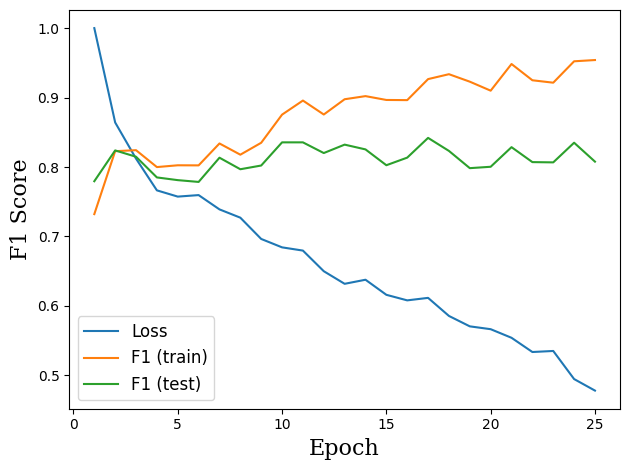

In [16]:
plot_training_results(results)

100%|██████████| 59/59 [00:13<00:00,  4.51it/s]

Evaluating model: bert_lstm_attn_842.pth
F1 score for model: 0.842


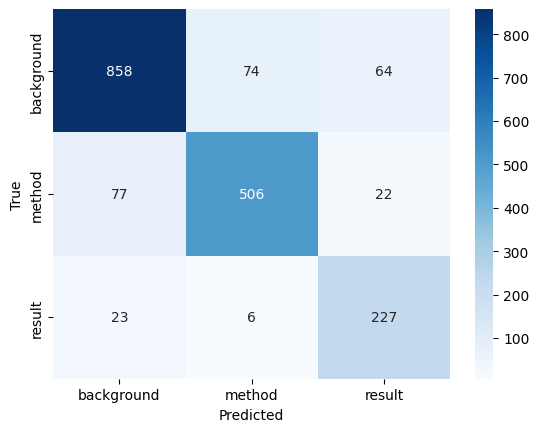

              precision    recall  f1-score   support

  background       0.90      0.86      0.88       996
      method       0.86      0.84      0.85       605
      result       0.73      0.89      0.80       256

    accuracy                           0.86      1857
   macro avg       0.83      0.86      0.84      1857
weighted avg       0.86      0.86      0.86      1857


In [17]:
model_path = 'bert_lstm_attn_842.pth'

eval_model = torch.load(model_path)

y_true, y_pred = evaluate(eval_model, val_dataloader, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)